In [1]:
!pip install torch torch_geometric torch_sparse torch_scatter torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


In [2]:
import pandas as pd
import networkx as nx
import os

# Set working directory
os.chdir('/Users/lijiayu/Desktop/MACS_30700_Final/')

# Load Model 2 (Homophily + Structure) edges and nodes
df_edges_model2 = pd.read_csv("model/model_2_edges.csv")
df_nodes_model2 = pd.read_csv("model/model_2_nodes.csv")

# Load Model 3 (Homophily-Only) edges and nodes
df_edges_model3 = pd.read_csv("model/model_3_edges.csv")
df_nodes_model3 = pd.read_csv("model/model_3_nodes.csv")

# Display basic dataset information
print("Model 2: ", df_edges_model2.shape, df_nodes_model2.shape)
print("Model 3: ", df_edges_model3.shape, df_nodes_model3.shape)


Model 2:  (24475, 2) (1000, 6)
Model 3:  (36347, 2) (1000, 6)


In [3]:
# Remove any NaN values in the edge list
df_edges_model2 = df_edges_model2.dropna()

# Convert node columns to integers (if applicable)
df_edges_model2["node_1"] = df_edges_model2["node_1"].astype(int)
df_edges_model2["node_2"] = df_edges_model2["node_2"].astype(int)

# Verify fix
print(f"Updated Model 2 Edge List: {df_edges_model2.shape[0]} edges")

Updated Model 2 Edge List: 24474 edges


In [4]:
# Print unique values for each categorical feature (excluding 'user_id')
for col in df_nodes_model2.columns:
    if col != "user_id":
        print(f"Unique values for {col}: {df_nodes_model2[col].dropna().unique().tolist()}\n")

Unique values for gender: ['Female', 'Male']

Unique values for age_group: ['45-64', '26-44', '65+', '15-18', '19-25']

Unique values for education_level: ['High', 'Middle', 'Low', 'No education']

Unique values for marital_status: ['Married', 'Divorced or Widowed', 'Cohabiting', 'Single']

Unique values for children_status: ['Yes', 'No']



In [5]:
import torch
from torch_geometric.utils import from_networkx

# Create NetworkX graphs
G_model2 = nx.from_pandas_edgelist(df_edges_model2, source="node_1", target="node_2")
G_model2.add_nodes_from(df_nodes_model2["user_id"])

G_model3 = nx.from_pandas_edgelist(df_edges_model3, source="node_1", target="node_2")
G_model3.add_nodes_from(df_nodes_model3["user_id"])

# Convert to PyTorch Geometric format
G_model2_torch = from_networkx(G_model2)
G_model3_torch = from_networkx(G_model3)

# Print graph info
print(G_model2_torch)
print(G_model3_torch)

/Users/lijiayu/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/lijiayu/anaconda3/lib/python3.11/site-packages/torch_scatter/_version_cpu.so, 0x0006): symbol not found in flat namespace '__ZN3c1017RegisterOperatorsD1Ev'
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/lijiayu/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: dlopen(/Users/lijiayu/anaconda3/lib/python3.11/site-packages/torch_cluster/_version_cpu.so, 0x0006): symbol not found in flat namespace '__ZN3c1017RegisterOperatorsD1Ev'
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/Users/lijiayu/anaconda3/lib/python3.11/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Dis

Data(edge_index=[2, 48936], num_nodes=1000)
Data(edge_index=[2, 72686], num_nodes=1000)


In [6]:
# Create a copy of the node dataset to modify
df_nodes_model2_encoded = df_nodes_model2.copy()
df_nodes_model3_encoded = df_nodes_model3.copy()

# Define ordinal encoding for age_group and education_level
ordinal_mappings = {
    "age_group": {"15-18": 1, "19-25": 2, "26-44": 3, "45-64": 4, "65+": 5},
    "education_level": {"No education": 0, "Low": 1, "Middle": 2, "High": 3}
}

# Apply ordinal encoding
for col, mapping in ordinal_mappings.items():
    df_nodes_model2_encoded[col] = df_nodes_model2_encoded[col].map(mapping).astype(float)
    df_nodes_model3_encoded[col] = df_nodes_model3_encoded[col].map(mapping).astype(float)

# One-hot encode nominal variables
df_nodes_model2_encoded = pd.get_dummies(df_nodes_model2_encoded, columns=["gender", "marital_status", "children_status"])
df_nodes_model3_encoded = pd.get_dummies(df_nodes_model3_encoded, columns=["gender", "marital_status", "children_status"])

# Drop 'user_id' and convert to tensor
df_nodes_model2_encoded.drop(columns=["user_id"], inplace=True)
df_nodes_model3_encoded.drop(columns=["user_id"], inplace=True)

node_features_model2 = torch.tensor(df_nodes_model2_encoded.values, dtype=torch.float)
node_features_model3 = torch.tensor(df_nodes_model3_encoded.values, dtype=torch.float)

# Assign to PyTorch Graph objects
G_model2_torch.x = node_features_model2
G_model3_torch.x = node_features_model3

# Print final feature shapes
print(f"Model 2 Encoded Node Features Shape: {node_features_model2.shape}")
print(f"Model 3 Encoded Node Features Shape: {node_features_model3.shape}")

Model 2 Encoded Node Features Shape: torch.Size([1000, 10])
Model 3 Encoded Node Features Shape: torch.Size([1000, 10])


In [7]:
from torch_geometric.utils import negative_sampling

# Dynamically determine the number of negative samples (same as positive edges)
num_neg_samples_model2 = len(df_edges_model2)
num_neg_samples_model3 = len(df_edges_model3)

# Use PyG's built-in negative sampling function
negative_edges_model2 = negative_sampling(
    edge_index=G_model2_torch.edge_index,
    num_nodes=G_model2_torch.num_nodes,
    num_neg_samples=num_neg_samples_model2
).view(2, -1)  # Reshape to (2, num_neg_samples)

negative_edges_model3 = negative_sampling(
    edge_index=G_model3_torch.edge_index,
    num_nodes=G_model3_torch.num_nodes,
    num_neg_samples=num_neg_samples_model3
).view(2, -1)  # Reshape to (2, num_neg_samples)

# Convert positive edges to PyTorch tensors
positive_edges_model2 = torch.tensor(df_edges_model2[["node_1", "node_2"]].values.T, dtype=torch.long)
positive_edges_model3 = torch.tensor(df_edges_model3[["node_1", "node_2"]].values.T, dtype=torch.long)

# Combine Positive and Negative Edges
all_edges_model2 = torch.cat((positive_edges_model2, negative_edges_model2), dim=1)
all_edges_model3 = torch.cat((positive_edges_model3, negative_edges_model3), dim=1)

# Create Labels (1 for positive edges, 0 for negative edges)
labels_model2 = torch.cat((torch.ones(positive_edges_model2.shape[1]), torch.zeros(negative_edges_model2.shape[1])), dim=0)
labels_model3 = torch.cat((torch.ones(positive_edges_model3.shape[1]), torch.zeros(negative_edges_model3.shape[1])), dim=0)

print(f"Model 2: {positive_edges_model2.shape[1]} positive, {negative_edges_model2.shape[1]} negative edges")
print(f"Model 3: {positive_edges_model3.shape[1]} positive, {negative_edges_model3.shape[1]} negative edges")

Model 2: 24474 positive, 24474 negative edges
Model 3: 36347 positive, 36347 negative edges


In [8]:
from sklearn.model_selection import train_test_split

# Split Model 2 edges into training (80%) and test (20%)
edges_train2, edges_test2, labels_train2, labels_test2 = train_test_split(
    all_edges_model2.T, labels_model2, test_size=0.2, random_state=42
)

# Split Model 3 edges into training (80%) and test (20%)
edges_train3, edges_test3, labels_train3, labels_test3 = train_test_split(
    all_edges_model3.T, labels_model3, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
edges_train2, edges_test2 = torch.tensor(edges_train2.T, dtype=torch.long), torch.tensor(edges_test2.T, dtype=torch.long)
edges_train3, edges_test3 = torch.tensor(edges_train3.T, dtype=torch.long), torch.tensor(edges_test3.T, dtype=torch.long)

labels_train2, labels_test2 = torch.tensor(labels_train2, dtype=torch.float32), torch.tensor(labels_test2, dtype=torch.float32)
labels_train3, labels_test3 = torch.tensor(labels_train3, dtype=torch.float32), torch.tensor(labels_test3, dtype=torch.float32)

print(f"Model 2: Train edges: {edges_train2.shape[1]}, Test edges: {edges_test2.shape[1]}")
print(f"Model 3: Train edges: {edges_train3.shape[1]}, Test edges: {edges_test3.shape[1]}")


Model 2: Train edges: 39158, Test edges: 9790
Model 3: Train edges: 58155, Test edges: 14539


/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_16675/4275109648.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edges_train2, edges_test2 = torch.tensor(edges_train2.T, dtype=torch.long), torch.tensor(edges_test2.T, dtype=torch.long)
/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_16675/4275109648.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edges_train3, edges_test3 = torch.tensor(edges_train3.T, dtype=torch.long), torch.tensor(edges_test3.T, dtype=torch.long)
/var/folders/yy/wn0z53b977q818d7g3560t400000gn/T/ipykernel_16675/4275109648.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceT

In [9]:
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import DataLoader

# Ensure device compatibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------------- GraphSAGE Model -------------------------
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import SAGEConv

# ------------------------- GraphSAGE Model -------------------------
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.2, use_third_layer=False):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.use_third_layer = use_third_layer

        if self.use_third_layer:
            self.conv3 = SAGEConv(out_channels, out_channels)

        self.linear = Linear(out_channels, 1)  # Predict edge probability
        self.dropout = dropout

    def forward(self, x, edge_index, edge_label_index):
        """GraphSAGE forward method for link prediction (unchanged)."""
        x = self.embed(x, edge_index)  # Calls the `embed()` function internally

        # Ensure edge_label_index is correctly shaped
        edge_label_index = edge_label_index.T if edge_label_index.shape[0] != 2 else edge_label_index

        # Extract edge embeddings
        src, dst = edge_label_index[0], edge_label_index[1]
        edge_embeddings = (x[src] + x[dst]) / 2  # Mean aggregation

        return self.linear(edge_embeddings).squeeze()

    def embed(self, x, edge_index):
        """ New function for node embeddings (does NOT require `edge_label_index`)."""
        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = F.dropout(x, p=self.dropout, training=False)

        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = F.dropout(x, p=self.dropout, training=False)

        if self.use_third_layer:
            x = self.conv3(x, edge_index)
            x = F.leaky_relu(x, negative_slope=0.01)
            x = F.dropout(x, p=self.dropout, training=False)

        return x  # Returns node embeddings

# ------------------------- Model Initialization -------------------------
# Move tensors to GPU/CPU
edges_train2, edges_test2 = edges_train2.to(device), edges_test2.to(device)
edges_train3, edges_test3 = edges_train3.to(device), edges_test3.to(device)
labels_train2, labels_test2 = labels_train2.to(device), labels_test2.to(device)
labels_train3, labels_test3 = labels_train3.to(device), labels_test3.to(device)

G_model2_torch = G_model2_torch.to(device)
G_model3_torch = G_model3_torch.to(device)

# Initialize GraphSAGE models
model2 = GraphSAGE(
    in_channels=node_features_model2.shape[1],
    hidden_channels=64,
    out_channels=32,
    dropout=0.2,
    use_third_layer=True
).to(device)

model3 = GraphSAGE(
    in_channels=node_features_model3.shape[1],
    hidden_channels=64,
    out_channels=32,
    dropout=0.2,
    use_third_layer=True
).to(device)

# Define optimizers
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=0.001, weight_decay=1e-4)
optimizer3 = torch.optim.AdamW(model3.parameters(), lr=0.001, weight_decay=1e-4)

# Define loss function
loss_fn = torch.nn.BCEWithLogitsLoss()

# ------------------------- Training Function -------------------------
def train(model, data, edges_train, labels_train, optimizer, epochs=30, batch_size=512):
    model.train()
    dataset = torch.utils.data.TensorDataset(edges_train.T, labels_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for batch_edges, batch_labels in dataloader:
            batch_edges, batch_labels = batch_edges.to(device), batch_labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            logits = model(data.x, data.edge_index, batch_edges.T)

            # Compute loss
            loss = loss_fn(logits, batch_labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Print loss every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

# ------------------------- Model Training -------------------------
print(" Training Model 2 (Homophily + Structure)...")
train(model2, G_model2_torch, edges_train2, labels_train2, optimizer2, epochs=20, batch_size=512)

print(" Training Model 3 (Homophily-Only)...")
train(model3, G_model3_torch, edges_train3, labels_train3, optimizer3, epochs=20, batch_size=512)


Using device: cpu
 Training Model 2 (Homophily + Structure)...
Epoch 5/20, Loss: 0.6467
Epoch 10/20, Loss: 0.6399
Epoch 15/20, Loss: 0.6382
Epoch 20/20, Loss: 0.6363
 Training Model 3 (Homophily-Only)...
Epoch 5/20, Loss: 0.6485
Epoch 10/20, Loss: 0.6438
Epoch 15/20, Loss: 0.6431
Epoch 20/20, Loss: 0.6424


In [10]:
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import log_loss, average_precision_score

def evaluate_model_extended(model, data, edges_test, labels_test, model_name):
    """Evaluates the model using multiple metrics including Log Loss & PR-AUC."""
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index, edges_test.T).sigmoid()
        y_pred = logits.cpu().numpy()
        y_true = labels_test.cpu().numpy()

    # Compute metrics
    auc = roc_auc_score(y_true, y_pred)
    precision_at_k = precision_score(y_true, (y_pred > 0.5).astype(int))
    recall = recall_score(y_true, (y_pred > 0.5).astype(int))
    f1 = f1_score(y_true, (y_pred > 0.5).astype(int))
    accuracy = accuracy_score(y_true, (y_pred > 0.5).astype(int))
    logloss = log_loss(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)

    print(f"\nEvaluation for {model_name}:")
    print(f"AUC-ROC: {auc:.3f}")
    print(f"Precision@K: {precision_at_k:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Log Loss: {logloss:.3f}")
    print(f"PR-AUC: {pr_auc:.3f}")

    return {
        "Model": model_name,
        "AUC-ROC": round(auc, 3),
        "Precision@K": round(precision_at_k, 3),
        "Recall": round(recall, 3),
        "F1-Score": round(f1, 3),
        "Accuracy": round(accuracy, 3),
        "Log Loss": round(logloss, 3),
        "PR-AUC": round(pr_auc, 3)
    }

# Evaluate both models and store results
results_extended = []
results_extended.append(evaluate_model_extended(model2, G_model2_torch, edges_test2, labels_test2, "Model 2: Homophily + Structure"))
results_extended.append(evaluate_model_extended(model3, G_model3_torch, edges_test3, labels_test3, "Model 3: Homophily-Only"))

# Convert to DataFrame and display
df_results_extended = pd.DataFrame(results_extended)

display(df_results_extended)



Evaluation for Model 2: Homophily + Structure:
AUC-ROC: 0.719
Precision@K: 0.612
Recall: 0.753
F1-Score: 0.675
Accuracy: 0.642
Log Loss: 0.630
PR-AUC: 0.715

Evaluation for Model 3: Homophily-Only:
AUC-ROC: 0.681
Precision@K: 0.609
Recall: 0.664
F1-Score: 0.635
Accuracy: 0.620
Log Loss: 0.650
PR-AUC: 0.689


,Model,AUC-ROC,Precision@K,Recall,F1-Score,Accuracy,Log Loss,PR-AUC
0,Model 2: Homophily + Structure,0.719,0.612,0.753,0.675,0.642,0.63,0.715
1,Model 3: Homophily-Only,0.681,0.609,0.664,0.635,0.620,0.65,0.689


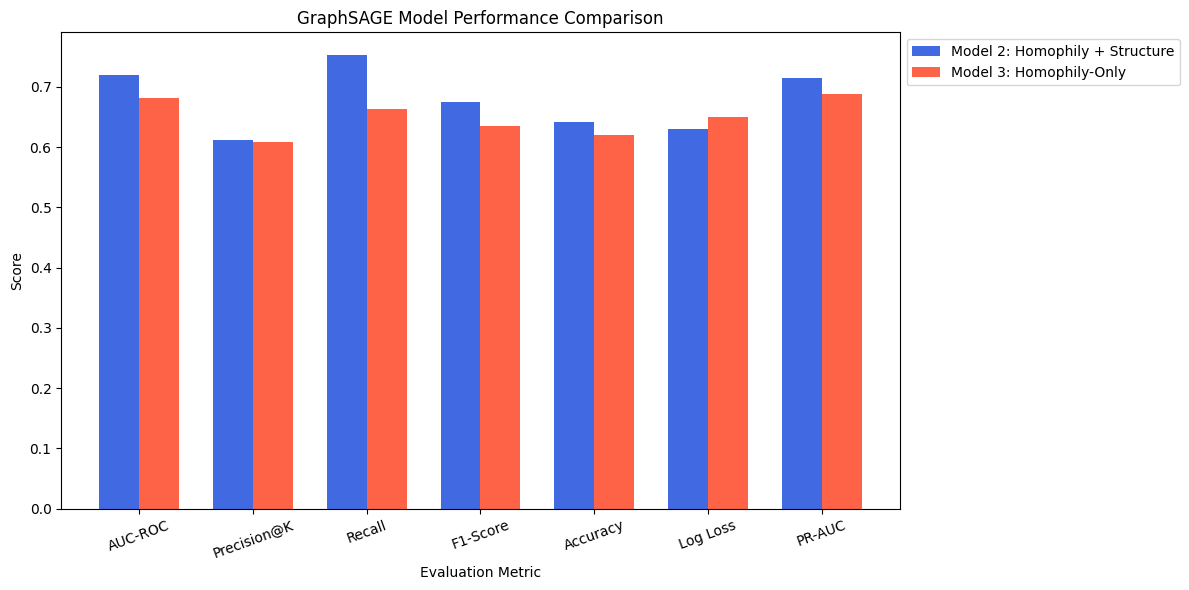

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Extract updated metrics
metrics = ["AUC-ROC", "Precision@K", "Recall", "F1-Score", "Accuracy", "Log Loss", "PR-AUC"]
model2_scores = df_results_extended.iloc[0, 1:].values  # Extract Model 2 scores
model3_scores = df_results_extended.iloc[1, 1:].values  # Extract Model 3 scores

# Define X-axis locations
x = np.arange(len(metrics))

# Plot settings
plt.figure(figsize=(12, 6))
bar_width = 0.35

# Bar plots
plt.bar(x - bar_width/2, model2_scores, bar_width, label="Model 2: Homophily + Structure", color="royalblue")
plt.bar(x + bar_width/2, model3_scores, bar_width, label="Model 3: Homophily-Only", color="tomato")

# Labels and title
plt.xlabel("Evaluation Metric")
plt.ylabel("Score")
plt.title("GraphSAGE Model Performance Comparison")
plt.xticks(ticks=x, labels=metrics, rotation=20)

# Move legend outside the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

# Adjust layout to fit legend
plt.tight_layout()

# Show plot
plt.show()



Precision-Recall & ROC Curves for Model 2 (Homophily + Structure)...


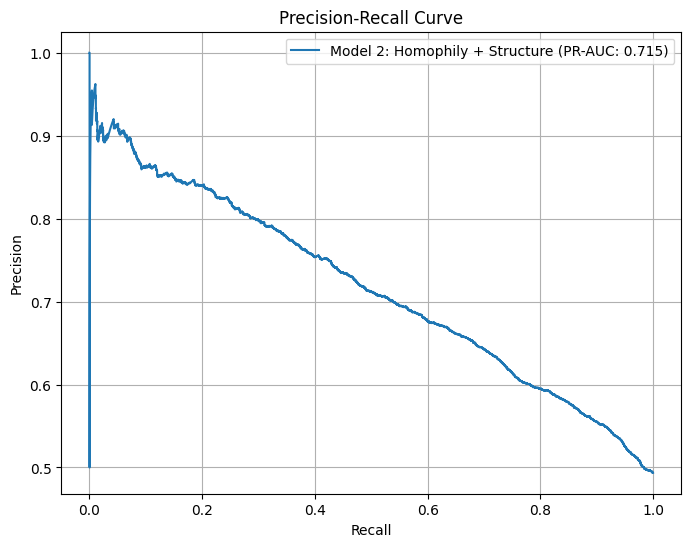

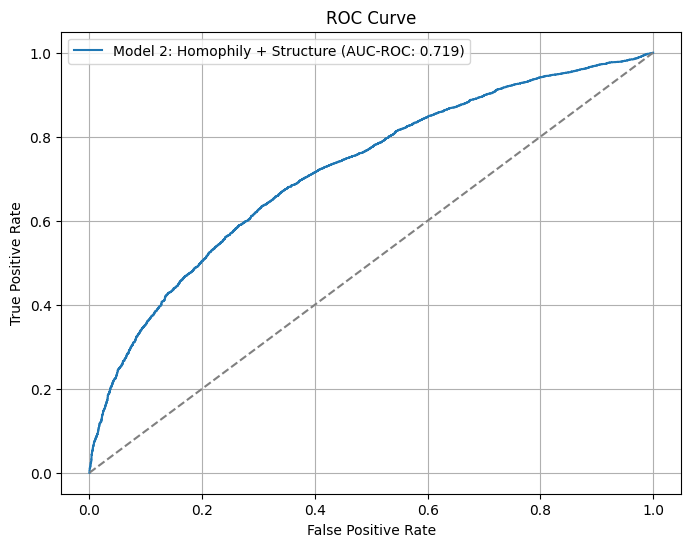


Precision-Recall & ROC Curves for Model 3 (Homophily-Only)...


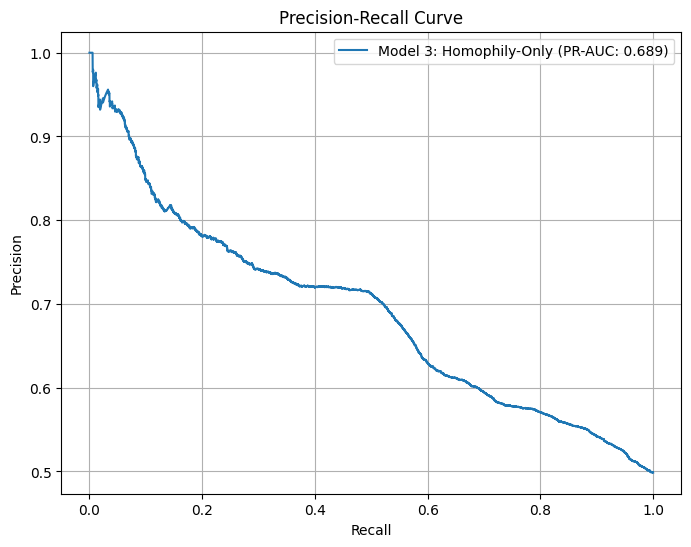

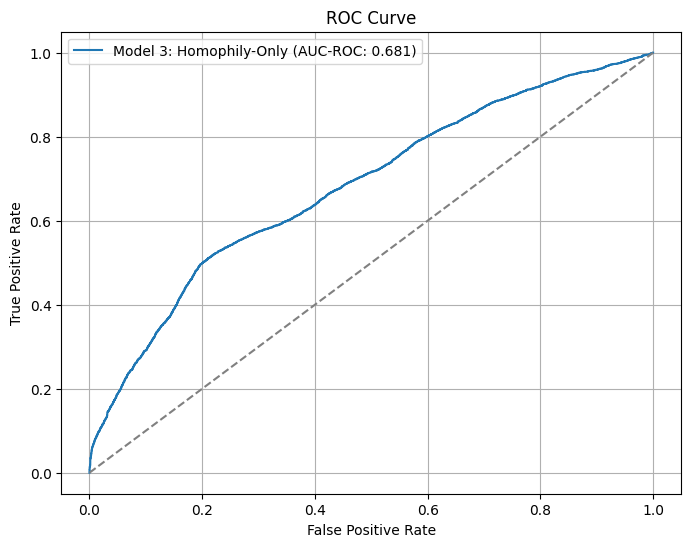

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve

def plot_precision_recall_roc(model, data, edges_test, labels_test, model_name):
    """Plots Precision-Recall and ROC curves."""
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index, edges_test.T).sigmoid()
        y_pred = logits.cpu().numpy()
        y_true = labels_test.cpu().numpy()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"{model_name} (PR-AUC: {average_precision_score(y_true, y_pred):.3f})", linestyle='-')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC-ROC: {roc_auc_score(y_true, y_pred):.3f})", linestyle='-')
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

# Generate plots for Model 2
print("\nPrecision-Recall & ROC Curves for Model 2 (Homophily + Structure)...")
plot_precision_recall_roc(model2, G_model2_torch, edges_test2, labels_test2, "Model 2: Homophily + Structure")

# Generate plots for Model 3
print("\nPrecision-Recall & ROC Curves for Model 3 (Homophily-Only)...")
plot_precision_recall_roc(model3, G_model3_torch, edges_test3, labels_test3, "Model 3: Homophily-Only")


In [35]:
import pandas as pd
import numpy as np
import torch
import networkx as nx
from torch_geometric.utils import from_networkx


# Load Pokec nodes dataset
df_pokec = pd.read_csv("dataset/pokec/final_pokec_dataset.csv")

print("\n Pokec Dataset Loaded Successfully!")
print(df_pokec.info())  # Overview of columns, data types, and missing values

# Create a copy for processing
df_pokec_processed = df_pokec.copy()

# Define mapping from Pokec dataset to Model 2’s expected feature names
feature_mapping = {
    "age_group_source": "age_group",
    "gender_source": "gender",
    "marital_status_source": "marital_status",
    "education_level_source": "education_level",
    "children_status_source": "children_status"
}

# Keep only the relevant columns
df_pokec_processed = df_pokec_processed[list(feature_mapping.keys())]  
df_pokec_processed.rename(columns=feature_mapping, inplace=True)

# Assign 'user_id' from the source column
df_pokec_processed["user_id"] = df_pokec["source"]

print("\n Updated Pokec Dataset Columns:")
print(df_pokec_processed.columns)


 Pokec Dataset Loaded Successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457849 entries, 0 to 457848
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   source                          457849 non-null  int64  
 1   target                          457849 non-null  int64  
 2   gender_source                   457849 non-null  object 
 3   completed_level_of_education_x  425217 non-null  object 
 4   children_x                      425217 non-null  object 
 5   marital_status_source           457849 non-null  object 
 6   age_group_source                457849 non-null  object 
 7   education_cluster_x             425217 non-null  float64
 8   children_cluster_x              425217 non-null  float64
 9   marital_cluster_x               425217 non-null  float64
 10  marital_status_original_x       425217 non-null  object 
 11  education_level_source          457849 no

In [36]:
from sklearn.preprocessing import MinMaxScaler

# Ordinal Encoding for categorical attributes
ordinal_mappings = {
    "age_group": {"15-18": 1, "19-25": 2, "26-44": 3, "45-64": 4, "65+": 5},
    "education_level": {"No education": 0, "Low": 1, "Middle": 2, "High": 3, "Vocational": 3}
}

for col, mapping in ordinal_mappings.items():
    df_pokec_processed[col] = df_pokec_processed[col].map(mapping).astype(float)

# One-Hot Encoding for categorical attributes
df_pokec_processed = pd.get_dummies(df_pokec_processed, columns=["gender", "marital_status", "children_status"])

# Normalize numerical features
scaler = MinMaxScaler()
df_pokec_processed.iloc[:, :] = scaler.fit_transform(df_pokec_processed)

# Set user_id as index
df_pokec_processed = df_pokec_processed.set_index("user_id")

print("\n Final Processed Pokec Dataset:")
print(df_pokec_processed.info())


 Final Processed Pokec Dataset:
<class 'pandas.core.frame.DataFrame'>
Float64Index: 457849 entries, 0.0 to 1.0
Data columns (total 10 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   age_group                           457849 non-null  float64
 1   education_level                     457849 non-null  float64
 2   gender_Female                       457849 non-null  float64
 3   gender_Male                         457849 non-null  float64
 4   marital_status_Cohabiting           457849 non-null  float64
 5   marital_status_Divorced or Widowed  457849 non-null  float64
 6   marital_status_Married              457849 non-null  float64
 7   marital_status_Single               457849 non-null  float64
 8   children_status_No                  457849 non-null  float64
 9   children_status_Yes                 457849 non-null  float64
dtypes: float64(10)
memory usage: 38.4 MB
None


In [37]:
# Load edges dataset
df_edges_pokec = pd.read_csv("dataset/pokec/final_pokec_dataset.csv")  

# Ensure correct column names for edges
df_edges_pokec = df_edges_pokec.rename(columns={"source": "node_1", "target": "node_2"})

# Create NetworkX graph
G_pokec_nx = nx.from_pandas_edgelist(df_edges_pokec, source="node_1", target="node_2")

print("\n Pokec NetworkX Graph Created.")

# Convert to PyTorch Geometric format
G_pokec_torch = from_networkx(G_pokec_nx)

print("\n Pokec Graph Converted to PyTorch Geometric Format.")

# Convert processed features to PyTorch tensor
node_features_pokec = torch.tensor(df_pokec_processed.values, dtype=torch.float)

# Assign features to PyG graph
G_pokec_torch.x = node_features_pokec

print("\n Pokec dataset is now fully aligned with Model 2 and ready for GraphSAGE.")

# Check feature consistency
print(f"\nPokec node feature shape: {G_pokec_torch.x.shape}")
print(f"Model 2 expected input shape: {model2.conv1.in_channels}")

/Users/lijiayu/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3508: DtypeWarning: Columns (3,4,10,14,15,21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)



 Pokec NetworkX Graph Created.

 Pokec Graph Converted to PyTorch Geometric Format.

 Pokec dataset is now fully aligned with Model 2 and ready for GraphSAGE.

Pokec node feature shape: torch.Size([457849, 10])
Model 2 expected input shape: 10


In [38]:
# Generate embeddings using Model 2 (Homophily + Structure)
pokec_embeddings_model2 = model2.embed(G_pokec_torch.x, G_pokec_torch.edge_index).detach().cpu().numpy()

# Generate embeddings using Model 3 (Homophily-Only)
pokec_embeddings_model3 = model3.embed(G_pokec_torch.x, G_pokec_torch.edge_index).detach().cpu().numpy()

# Save embeddings for future use
np.save("pokec_model2_embeddings.npy", pokec_embeddings_model2)
np.save("pokec_model3_embeddings.npy", pokec_embeddings_model3)

print("\n Node embeddings for Pokec successfully generated and saved.")


 Node embeddings for Pokec successfully generated and saved.


In [39]:
from torch_geometric.utils import negative_sampling

# Convert Pokec edges into PyTorch format
edges_pokec = torch.tensor(df_edges_pokec[["node_1", "node_2"]].values.T, dtype=torch.long).to(device)


# Get number of nodes
num_nodes = G_pokec_torch.num_nodes  

# Generate negative edges ensuring they are within the valid node range
negative_edges_pokec = negative_sampling(
    edge_index=edges_pokec, 
    num_nodes=num_nodes,  
    num_neg_samples=edges_pokec.shape[1]  # Match positive edge count
)

# Ensure all sampled nodes are within valid index range
valid_mask = (negative_edges_pokec[0] < num_nodes) & (negative_edges_pokec[1] < num_nodes)
negative_edges_pokec = negative_edges_pokec[:, valid_mask]

print(f"\n Successfully generated {negative_edges_pokec.shape[1]} valid negative edges.")



 Successfully generated 457849 valid negative edges.


In [40]:
# Combine positive and negative edges
all_edges_pokec = torch.cat((edges_pokec, negative_edges_pokec), dim=1)

# Create edge labels (1 for real edges, 0 for negative edges)
labels_pokec = torch.cat((torch.ones(edges_pokec.shape[1]), torch.zeros(negative_edges_pokec.shape[1])), dim=0).to(device)

# Remove any edges with invalid node indices
valid_edges_mask = (all_edges_pokec[0] < num_nodes) & (all_edges_pokec[1] < num_nodes)
all_edges_pokec = all_edges_pokec[:, valid_edges_mask]
labels_pokec = labels_pokec[valid_edges_mask]  # Ensure labels match the filtered edges

print(f"\n Final edge dataset created with {all_edges_pokec.shape[1]} valid edges (real + negative).")



 Final edge dataset created with 493784 valid edges (real + negative).


In [41]:
def predict_pokec_links(model, data, edges):
    """Predict link existence probabilities using the trained GraphSAGE model."""
    model.eval()
    edges = edges.to(device)  # Ensure edges are on the correct device

    # Ensure edges are in the correct shape
    if edges.shape[0] != 2:
        edges = edges.T

    with torch.no_grad():
        logits = model(data.x, data.edge_index, edges).sigmoid()  # Convert logits to probabilities
        predictions = logits.cpu().numpy()  # Convert to NumPy

    return predictions

# Predict links using Model 2 (Homophily + Structure)
pokec_predicted_links_model2 = predict_pokec_links(model2, G_pokec_torch, all_edges_pokec)

# Predict links using Model 3 (Homophily-Only)
pokec_predicted_links_model3 = predict_pokec_links(model3, G_pokec_torch, all_edges_pokec)

# Save predictions
import numpy as np
np.save("pokec_model2_predicted_links.npy", pokec_predicted_links_model2)
np.save("pokec_model3_predicted_links.npy", pokec_predicted_links_model3)

print("\n Link predictions for Pokec successfully generated and saved.")



 Link predictions for Pokec successfully generated and saved.


In [42]:
def evaluate_model_on_pokec(predictions, labels, model_name):
    """Evaluates the model using multiple metrics and stores results in a DataFrame."""
    y_pred = predictions
    y_true = labels.cpu().numpy()

    # Compute metrics
    auc = roc_auc_score(y_true, y_pred)
    precision_at_k = precision_score(y_true, (y_pred > 0.5).astype(int))
    recall = recall_score(y_true, (y_pred > 0.5).astype(int))
    f1 = f1_score(y_true, (y_pred > 0.5).astype(int))
    accuracy = accuracy_score(y_true, (y_pred > 0.5).astype(int))

    print(f"\nEvaluation for {model_name}:")
    print(f"AUC-ROC: {auc:.3f}")
    print(f"Precision@K: {precision_at_k:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"Accuracy: {accuracy:.3f}")

    return {
        "Model": model_name,
        "AUC-ROC": round(auc, 3),
        "Precision@K": round(precision_at_k, 3),
        "Recall": round(recall, 3),
        "F1-Score": round(f1, 3),
        "Accuracy": round(accuracy, 3)
    }

# Load predictions
pokec_predicted_links_model2 = np.load("pokec_model2_predicted_links.npy")
pokec_predicted_links_model3 = np.load("pokec_model3_predicted_links.npy")

# Evaluate models
results_pokec = []
results_pokec.append(evaluate_model_on_pokec(pokec_predicted_links_model2, labels_pokec, "Model 2: Homophily + Structure"))
results_pokec.append(evaluate_model_on_pokec(pokec_predicted_links_model3, labels_pokec, "Model 3: Homophily-Only"))

# Convert to DataFrame and display
df_results_pokec = pd.DataFrame(results_pokec)

display(df_results_pokec)



Evaluation for Model 2: Homophily + Structure:
AUC-ROC: 0.503
Precision@K: 0.089
Recall: 0.006
F1-Score: 0.011
Accuracy: 0.923


/Users/lijiayu/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Evaluation for Model 3: Homophily-Only:
AUC-ROC: 0.503
Precision@K: 0.000
Recall: 0.000
F1-Score: 0.000
Accuracy: 0.927


,Model,AUC-ROC,Precision@K,Recall,F1-Score,Accuracy
0,Model 2: Homophily + Structure,0.503,0.089,0.006,0.011,0.923
1,Model 3: Homophily-Only,0.503,0.000,0.000,0.000,0.927


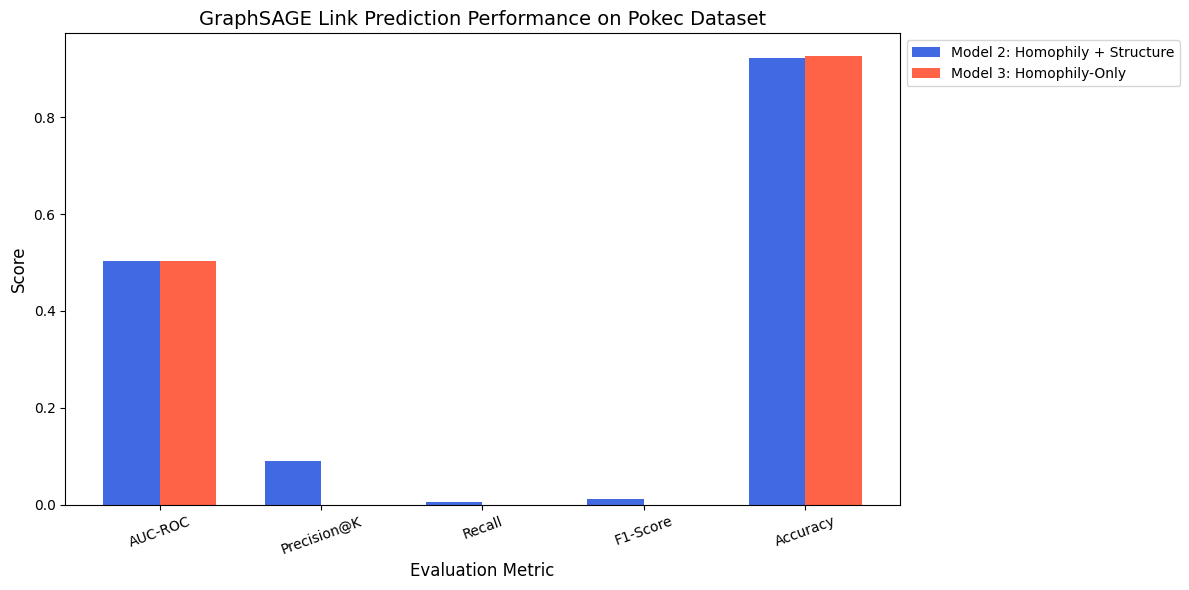

In [45]:
# Extract updated metrics from Pokec results
metrics = ["AUC-ROC", "Precision@K", "Recall", "F1-Score", "Accuracy"]
model2_scores = df_results_pokec.iloc[0, 1:].values  # Extract Model 2 scores
model3_scores = df_results_pokec.iloc[1, 1:].values  # Extract Model 3 scores

# Define X-axis locations
x = np.arange(len(metrics))

# Plot settings
plt.figure(figsize=(12, 6))
bar_width = 0.35

# Bar plots
plt.bar(x - bar_width/2, model2_scores, bar_width, label="Model 2: Homophily + Structure", color="royalblue")
plt.bar(x + bar_width/2, model3_scores, bar_width, label="Model 3: Homophily-Only", color="tomato")

# Labels and title
plt.xlabel("Evaluation Metric", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("GraphSAGE Link Prediction Performance on Pokec Dataset", fontsize=14)
plt.xticks(ticks=x, labels=metrics, rotation=20)

# Move legend outside the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)

# Adjust layout to fit legend
plt.tight_layout()

# Show plot
plt.show()


 Evaluating Link Prediction Performance for Model 2 (Homophily + Structure) on Pokec Dataset...


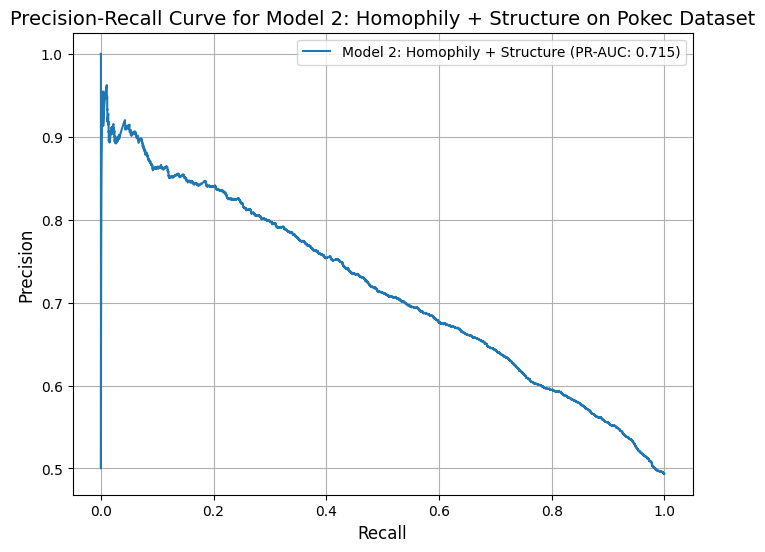

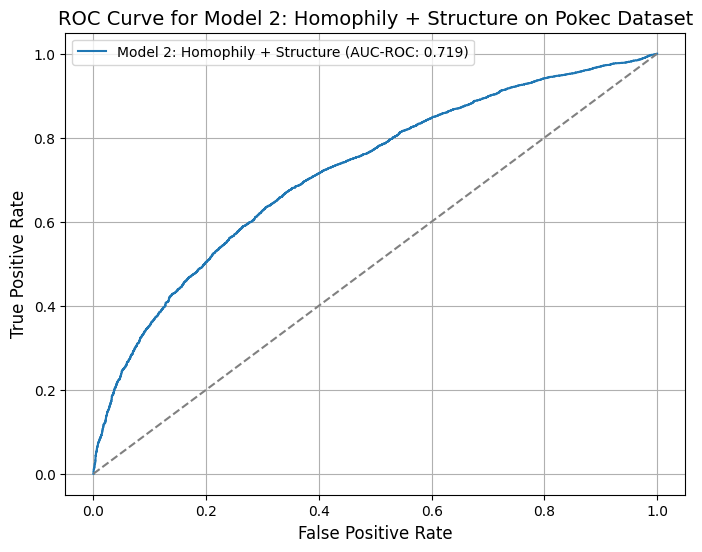


 Evaluating Link Prediction Performance for Model 3 (Homophily-Only) on Pokec Dataset...


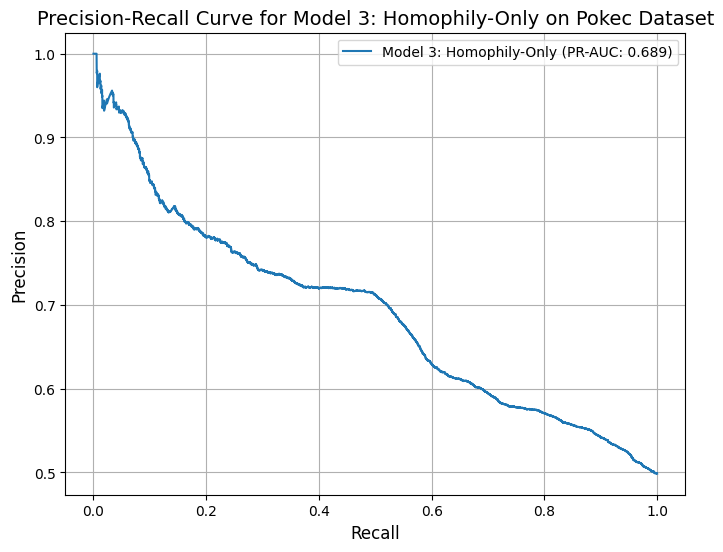

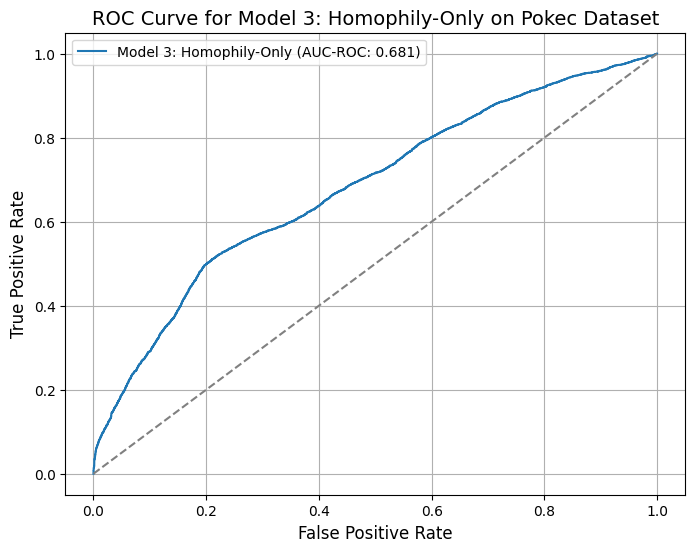

In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score

def plot_precision_recall_roc_pokec(model, data, edges_test, labels_test, model_name):
    """Plots Precision-Recall and ROC curves for link prediction in the Pokec dataset."""
    model.eval()
    with torch.no_grad():
        logits = model(data.x, data.edge_index, edges_test.T).sigmoid()
        y_pred = logits.cpu().numpy()
        y_true = labels_test.cpu().numpy()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"{model_name} (PR-AUC: {pr_auc:.3f})", linestyle='-')
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.title(f"Precision-Recall Curve for {model_name} on Pokec Dataset", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{model_name} (AUC-ROC: {auc_roc:.3f})", linestyle='-')
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier baseline
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title(f"ROC Curve for {model_name} on Pokec Dataset", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid()
    plt.show()

# Generate plots for Model 2
print("\n Evaluating Link Prediction Performance for Model 2 (Homophily + Structure) on Pokec Dataset...")
plot_precision_recall_roc_pokec(model2, G_model2_torch, edges_test2, labels_test2, "Model 2: Homophily + Structure")

# Generate plots for Model 3
print("\n Evaluating Link Prediction Performance for Model 3 (Homophily-Only) on Pokec Dataset...")
plot_precision_recall_roc_pokec(model3, G_model3_torch, edges_test3, labels_test3, "Model 3: Homophily-Only")
